<a href="https://colab.research.google.com/github/veapasichnyk/Applied-Data-Science-Capstone/blob/main/HW_2_2_%D0%9D%D0%B5%D0%B7%D0%B1%D0%B0%D0%BB%D0%B0%D0%BD%D1%81%D0%BE%D0%B2%D0%B0%D0%BD%D0%B0_%D0%B1%D0%B0%D0%B3%D0%B0%D1%82%D0%BE%D0%BA%D0%BB%D0%B0%D1%81%D0%BE%D0%B2%D0%B0_%D0%BA%D0%BB%D0%B0%D1%81%D0%B8%D1%84%D1%96%D0%BA%D0%B0%D1%86%D1%96%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

In [1]:
!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [3]:
train_df = pd.read_csv('customer_segmentation_train.csv')

In [4]:
train_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
X = train_df.drop('Segmentation', axis=1)
y = train_df['Segmentation']

In [6]:
#Визначення типів ознак
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Індекси категоріальних ознак у спільному масиві
all_features = num_cols + cat_cols
cat_feature_indices = [all_features.index(col) for col in cat_cols]

In [7]:
# Пайплайн для числових ознак
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Пайплайн для категоріальних ознак
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Об'єднання обох пайплайнів у загальний
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


In [8]:
#Розділення на train/test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [9]:
# Трансформуємо тренувальні дані
X_train_transformed = preprocessor.fit_transform(X_train_raw)

In [10]:
#SMOTE (тільки для числових ознак)
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_transformed, y_train)

In [11]:
#SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train_transformed, y_train)

In [12]:
# SMOTENC
# Cтворюємо препроцесор, який не кодує категоріальні ознаки
# (щоб SMOTENC міг працювати напряму з категоріями)
simple_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

simple_preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', simple_cat_pipeline, cat_cols)
])

# Трансформуємо X_train (без кодування)
X_train_simple = simple_preprocessor.fit_transform(X_train_raw)

In [13]:
# Застосовуємо SMOTENC
smotenc = SMOTENC(
    categorical_features=cat_feature_indices,
    random_state=42
)

X_smotenc, y_smotenc = smotenc.fit_resample(X_train_simple, y_train)

In [14]:
print("Original:", X_train_raw.shape, y_train.value_counts())
print("SMOTE:", X_smote.shape, pd.Series(y_smote).value_counts())
print("SMOTE-Tomek:", X_smote_tomek.shape, pd.Series(y_smote_tomek).value_counts())
print("SMOTENC:", X_smotenc.shape, pd.Series(y_smotenc).value_counts())

Original: (6454, 10) Segmentation
D    1814
A    1578
C    1576
B    1486
Name: count, dtype: int64
SMOTE: (7256, 23) Segmentation
A    1814
B    1814
C    1814
D    1814
Name: count, dtype: int64
SMOTE-Tomek: (5316, 23) Segmentation
C    1388
D    1369
B    1303
A    1256
Name: count, dtype: int64
SMOTENC: (7256, 10) Segmentation
A    1814
B    1814
C    1814
D    1814
Name: count, dtype: int64


**Спостереження**

Як бачимо з Original ми мали початковий дисбаланс (1814-1486).

SMOTE і SMOTENC збалансували всі класи до 1814 записів.

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [15]:
#One-vs-Rest LogisticRegression на оригінальних сирих даних

# Повний pipeline
pipeline_original = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
])

# Навчання
pipeline_original.fit(X_train_raw, y_train)

# Прогноз
y_pred_original = pipeline_original.predict(X_test_raw)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [16]:
#One-vs-Rest LogisticRegression на SMOTE

# Модель (без препроцесора, бо вже трансформовано)
pipeline_smote = Pipeline([
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
])

# Навчання
pipeline_smote.fit(X_smote, y_smote)

# Трансформуємо тест, бо модель очікує ті самі ознаки
X_test_transformed = preprocessor.transform(X_test_raw)
y_pred_smote = pipeline_smote.predict(X_test_transformed)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [17]:
#One-vs-Rest LogisticRegression на SMOTE-Tomek

pipeline_smote_tomek = Pipeline([
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)))
])

# Навчання
pipeline_smote_tomek.fit(X_smote_tomek, y_smote_tomek)

# Прогноз
y_pred_smote_tomek = pipeline_smote_tomek.predict(X_test_transformed)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# Звіт
print("=== Оригінальні дані ===")
print(classification_report(y_test, y_pred_original))
print("=== SMOTE ===")
print(classification_report(y_test, y_pred_smote))
print("=== SMOTE-Tomek ===")
print(classification_report(y_test, y_pred_smote_tomek))

=== Оригінальні дані ===
              precision    recall  f1-score   support

           A       0.40      0.46      0.43       394
           B       0.34      0.15      0.21       372
           C       0.48      0.59      0.53       394
           D       0.64      0.73      0.68       454

    accuracy                           0.50      1614
   macro avg       0.47      0.48      0.46      1614
weighted avg       0.47      0.50      0.47      1614

=== SMOTE ===
              precision    recall  f1-score   support

           A       0.42      0.52      0.47       394
           B       0.36      0.20      0.26       372
           C       0.51      0.58      0.54       394
           D       0.68      0.69      0.68       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614

=== SMOTE-Tomek ===
              precision    recall  f1-score   support

           A    

**Спостереження**

Для порівняння моделей я б обрала Macro average F1 - так як вона не залежить від розміру класів і показує, як добре модель працює для кожного класу однаково.

У нашому випадку ми бачимо зростання з 0.46 (Original) → 0.49 (SMOTE) → 0.48 (SMOTE-Tomek).

SMOTE покращує загальний баланс моделі, особливо для класу A.

SMOTE-Tomek трохи погіршує результати для класу A, але значно покращує для класу C.

Клас B залишається "важким" для моделі у всіх варіантах.


In [19]:
#Функція побудови ConfusionMatrixDisplay
#(для візуального розуміння, які класи плутаються)

def plot_normalized_confusion(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=['A', 'B', 'C', 'D'], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C', 'D'])
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    ax.set_title(title)
    ax.grid(False)

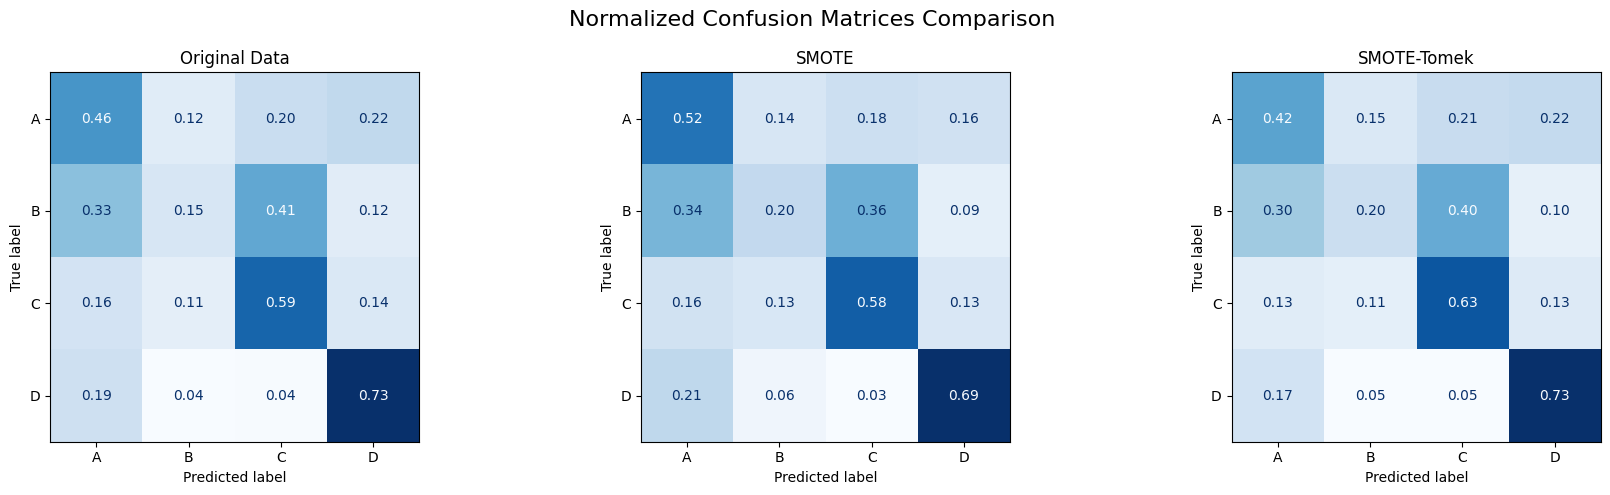

In [20]:
# Створення фігури з 3 підграфіками
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Нормалізовані матриці для кожної моделі
plot_normalized_confusion(y_test, y_pred_original, title="Original Data", ax=ax[0])
plot_normalized_confusion(y_test, y_pred_smote, title="SMOTE", ax=ax[1])
plot_normalized_confusion(y_test, y_pred_smote_tomek, title="SMOTE-Tomek", ax=ax[2])

# Додавання заголовка для всіх графіків
fig.suptitle("Normalized Confusion Matrices Comparison", fontsize=16)
plt.tight_layout()
plt.show()

**Спостереження**

- Original Data (ліва матриця):

Клас D передбачається найкраще: 73% правильних передбачень.

Клас B має сильну плутанину з класом C (41%).

Загалом, видно деяке домінування класу D, інші класи мають змішану точність.

- SMOTE (центральна матриця):

Мета SMOTE - збалансувати класи, і це видно: класи стали передбачуваніші.

Клас A: 52% (краще, ніж в оригіналі).

Клас B: менше плутанини з класом C (36%).

Але помітна плутанина залишилась між усіма класами, хоч і трохи зменшилась.

- SMOTE-Tomek (права матриця):

Найвищий показник точності для класу C: 63%.

Краще відокремлюються класи A, B і C.

Клас D стабільно добре передбачається (так само як в оригіналі - 73%).


Ще цікаво подивитись на розподіл класів в оригінальному наборі, SMOTE та SMOTE-Tomek - використаю PCA для візуалізації в 2D

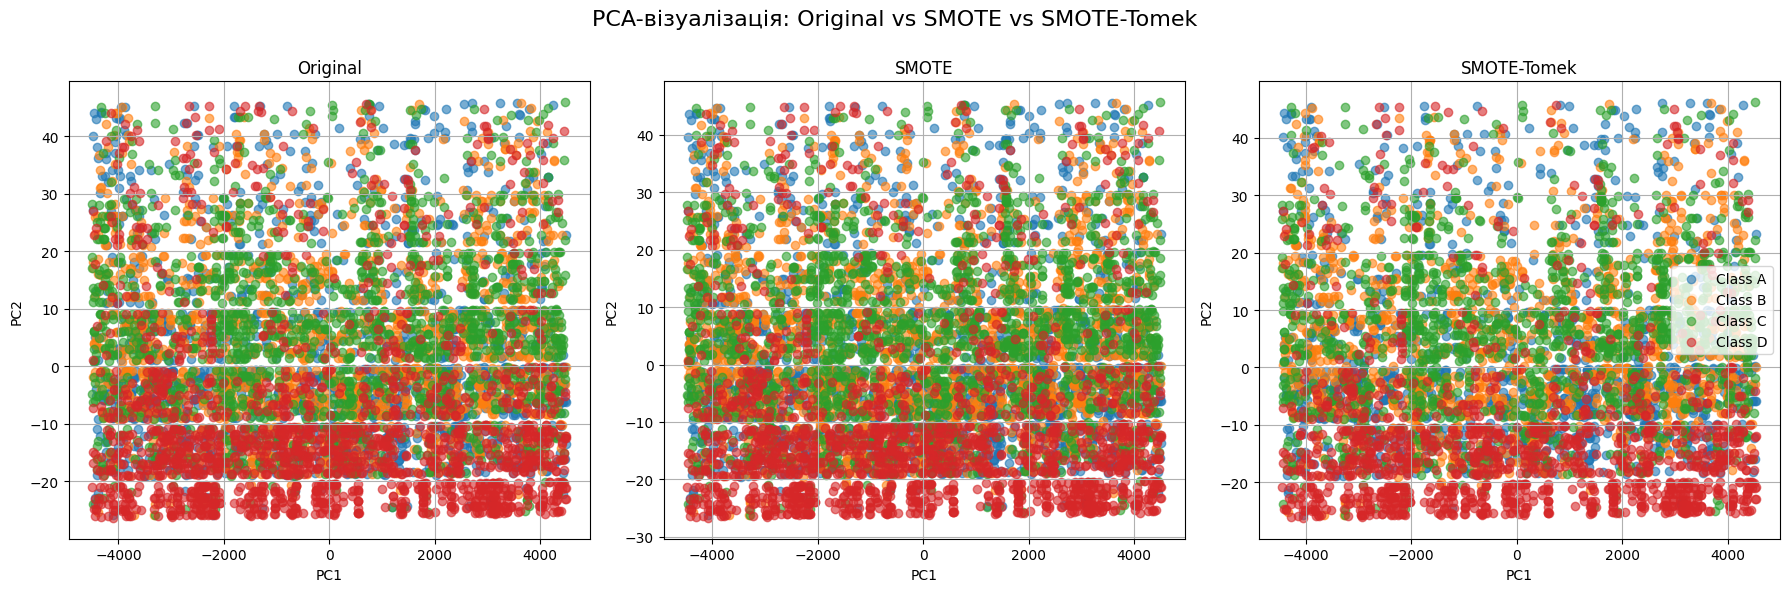

In [27]:
# Створюємо список для зручності
datasets = [
    ("Original", X_train_transformed, y_train),
    ("SMOTE", X_smote, y_smote),
    ("SMOTE-Tomek", X_smote_tomek, y_smote_tomek)
]

# Створюємо фігуру з 3 підграфіками
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("PCA-візуалізація: Original vs SMOTE vs SMOTE-Tomek", fontsize=16)

for ax, (title, X_data, y_data) in zip(axes, datasets):
    # PCA до 2 компонент
    X_pca = PCA(n_components=2).fit_transform(X_data)

    # Для кожного класу — scatter plot
    for label in sorted(set(y_data)):
        ax.scatter(
            X_pca[y_data == label, 0],
            X_pca[y_data == label, 1],
            label=f'Class {label}',
            alpha=0.6
        )

    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True)

# Легенда на останньому підграфіку
axes[-1].legend(loc='right')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Висновок**

На мою думку, ми не бачимо значного покращення між моделями, тому що невдало підібрана модель. Логістична регресія - лінійна модель, вона обмежена в можливості розділяти складні або перекриті класи (що власне ми й бачимо на графіках) і One-vs-Rest підсилює проблему асиметрії.
У підході OvR для кожного класу тренується окрема логістична регресія: "Цей клас" vs "Усі інші". Якщо клас малий, то позитивних прикладів дуже мало, а негативів - багато (цим пояснюється чому клас B залишається "важким" для моделі у всіх варіантах). Якщо класи не лінійно віддільні , SMOTE не допоможе, бо логістична регресія все одно не зможе провести адекватну межу. Тобто навіть якщо з’являється більше синтетичних зразків, модель не вміє ними скористатися.
Гіпотеза: модель "впирається" в лінійність, а не в кількість прикладів.

